# Data preparation

In [1]:
# First, let's open data
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR



pd.set_option('display.max_columns', 500)
source_data = pd.read_csv('2.csv', sep=';')
source_data.head()


# known distr_ids
known_distr_ids = [i for i in range(1,18)]
known_distr_ids.remove(12)
known_distr_ids.remove(13)
known_distr_ids.remove(15)
known_distr_ids.remove(16)

distr_bought_columns = ['client_distr{}_bought'.format(i) for i in known_distr_ids]
distr_bought_columns.append('client_own_bought')

distr_price_columns = ['client_distr{}_price'.format(i) for i in known_distr_ids]
distr_price_columns.append('client_own_price')

# fill all bought columns NaN with zeros
source_data[distr_bought_columns] = source_data[distr_bought_columns].fillna(0)

source_data.head()

,dt,drug_name,mnth,dow,m_in_q,working_day,season,drug_ag_id,client_id,drug_avail,own_amount,to_over_margin,first_price,action,lower_limit,upper_limit,client_own_price,client_own_bought,client_distr1_price,client_distr1_bought,client_distr2_price,client_distr2_bought,client_distr3_price,client_distr3_bought,client_distr4_price,client_distr4_bought,client_distr5_price,client_distr5_bought,client_distr6_price,client_distr6_bought,client_distr7_price,client_distr7_bought,client_distr8_price,client_distr8_bought,client_distr9_price,client_distr9_bought,client_distr10_price,client_distr10_bought,client_distr11_price,client_distr11_bought,client_distr14_price,client_distr14_bought,client_distr17_price,client_distr17_bought
0,2018-01-01,Актовегин р-р д/ин. амп. 40мг/мл 5мл №5,1,1,1,False,Зима,880000000000E261,9006000000000294,True,181.0,True,NaN,False,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
1,2018-01-01,Актовегин р-р д/ин. амп. 40мг/мл 5мл №5,1,1,1,False,Зима,880000000000E261,90060000000002C7,True,181.0,True,NaN,False,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
2,2018-01-01,Актовегин р-р д/ин. амп. 40мг/мл 5мл №5,1,1,1,False,Зима,880000000000E261,90060000000002FE,True,181.0,True,NaN,False,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
3,2018-01-01,Актовегин р-р д/ин. амп. 40мг/мл 5мл №5,1,1,1,False,Зима,880000000000E261,9006000000000322,True,181.0,True,NaN,False,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
4,2018-01-01,Актовегин р-р д/ин. амп. 40мг/мл 5мл №5,1,1,1,False,Зима,880000000000E261,900600000000067E,True,181.0,True,NaN,False,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0


In [2]:
# Counts total number of bought items for current data row
def get_total_bought(df):
    bought = 0    
    for i in known_distr_ids:
        bought = bought + df['client_distr{}_bought'.format(i)]
    bought = bought + df['client_own_bought'.format(i)]
    return bought

# Counts weighted price for given row
# If total number of bought items for current data row is 0, this is simple average through all distributors
# We skip columns with NaN in price for this calculation
def get_weighted_price(df):    
    total_bought = get_total_bought(df)
    # print('total_bought: ', total_bought)
    weighted_price = 0
    
    own_price = df['client_own_price']
    # print('own_price: ', own_price)
    own_bought = df['client_own_bought']
    # print('own_bought: ', own_bought)
    
    known_prices_count = sum(not math.isnan(df['client_distr{}_price'.format(i)]) for i in known_distr_ids)
    if not math.isnan(own_price):
        known_prices_count = known_prices_count + 1    
    # print('known_prices_count: ', known_prices_count)
    
    if known_prices_count == 0:
        return math.nan    
    
    if not math.isnan(own_price):
        if total_bought > 0: 
            own_bought_weight = own_bought / total_bought
        else:
            own_bought_weight = 1 / known_prices_count

        weighted_price = weighted_price + own_bought_weight * own_price
    
    for i in known_distr_ids:
        # print('client index: ', i)
        distr_price = df['client_distr{}_price'.format(i)]
        # print('client_price: ', client_price)
        distr_bought = df['client_distr{}_bought'.format(i)]
        # print('client_bought: ', client_bought)
        if math.isnan(distr_price):
            # print('skipping this client: ', i)
            continue;
        
        if total_bought > 0: 
            distr_bought_weight = distr_bought / total_bought
        else:
            distr_bought_weight = 1 / known_prices_count
            
        weighted_price = weighted_price + distr_bought_weight * distr_price

    
    
    return weighted_price
  
  # Counts min price for given row (if total_bought > 0)
# If total number of bought items for current data row is 0, this is simple average through all distributors
# We skip columns with NaN in price for this calculation
def get_wighted_price_if_bought(df):    
    total_bought = get_total_bought(df)
    
    if total_bought == 0:
        return math.nan
      
    # print('total_bought: ', total_bought)
    weighted_price = 0
    
    own_price = df['client_own_price']
    # print('own_price: ', own_price)
    own_bought = df['client_own_bought']
    # print('own_bought: ', own_bought)
    
    known_prices_count = sum(not math.isnan(df['client_distr{}_price'.format(i)]) for i in known_distr_ids)
    if not math.isnan(own_price):
        known_prices_count = known_prices_count + 1    
    # print('known_prices_count: ', known_prices_count)
    
    if known_prices_count == 0:
        return math.nan    
    
    if not math.isnan(own_price):
        own_bought_weight = own_bought / total_bought
        weighted_price = weighted_price + own_bought_weight * own_price
    
    for i in known_distr_ids:
        # print('client index: ', i)
        distr_price = df['client_distr{}_price'.format(i)]
        # print('client_price: ', client_price)
        distr_bought = df['client_distr{}_bought'.format(i)]
        # print('client_bought: ', client_bought)
        if math.isnan(distr_price):
            # print('skipping this client: ', i)
            continue;
        
        distr_bought_weight = distr_bought / total_bought            
        weighted_price = weighted_price + distr_bought_weight * distr_price

    
    
    return weighted_price

In [4]:
# add columns total_bought, weighted_price to data
source_data['total_bought'] = source_data.apply(lambda x: get_total_bought(x), axis=1)
source_data['weighted_price'] = source_data.apply(lambda x: get_weighted_price(x), axis=1)
source_data['weighted_price_if_bought'] = source_data.apply(lambda x: get_wighted_price_if_bought(x), axis=1)

source_data.head()

,dt,drug_name,mnth,dow,m_in_q,working_day,season,drug_ag_id,client_id,drug_avail,own_amount,to_over_margin,first_price,action,lower_limit,upper_limit,client_own_price,client_own_bought,client_distr1_price,client_distr1_bought,client_distr2_price,client_distr2_bought,client_distr3_price,client_distr3_bought,client_distr4_price,client_distr4_bought,client_distr5_price,client_distr5_bought,client_distr6_price,client_distr6_bought,client_distr7_price,client_distr7_bought,client_distr8_price,client_distr8_bought,client_distr9_price,client_distr9_bought,client_distr10_price,client_distr10_bought,client_distr11_price,client_distr11_bought,client_distr14_price,client_distr14_bought,client_distr17_price,client_distr17_bought,total_bought,weighted_price,weighted_price_if_bought
0,2018-01-01,Актовегин р-р д/ин. амп. 40мг/мл 5мл №5,1,1,1,False,Зима,880000000000E261,9006000000000294,True,181.0,True,NaN,False,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN
1,2018-01-01,Актовегин р-р д/ин. амп. 40мг/мл 5мл №5,1,1,1,False,Зима,880000000000E261,90060000000002C7,True,181.0,True,NaN,False,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN
2,2018-01-01,Актовегин р-р д/ин. амп. 40мг/мл 5мл №5,1,1,1,False,Зима,880000000000E261,90060000000002FE,True,181.0,True,NaN,False,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN
3,2018-01-01,Актовегин р-р д/ин. амп. 40мг/мл 5мл №5,1,1,1,False,Зима,880000000000E261,9006000000000322,True,181.0,True,NaN,False,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN
4,2018-01-01,Актовегин р-р д/ин. амп. 40мг/мл 5мл №5,1,1,1,False,Зима,880000000000E261,900600000000067E,True,181.0,True,NaN,False,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN


# Correlation between features on complete dataset

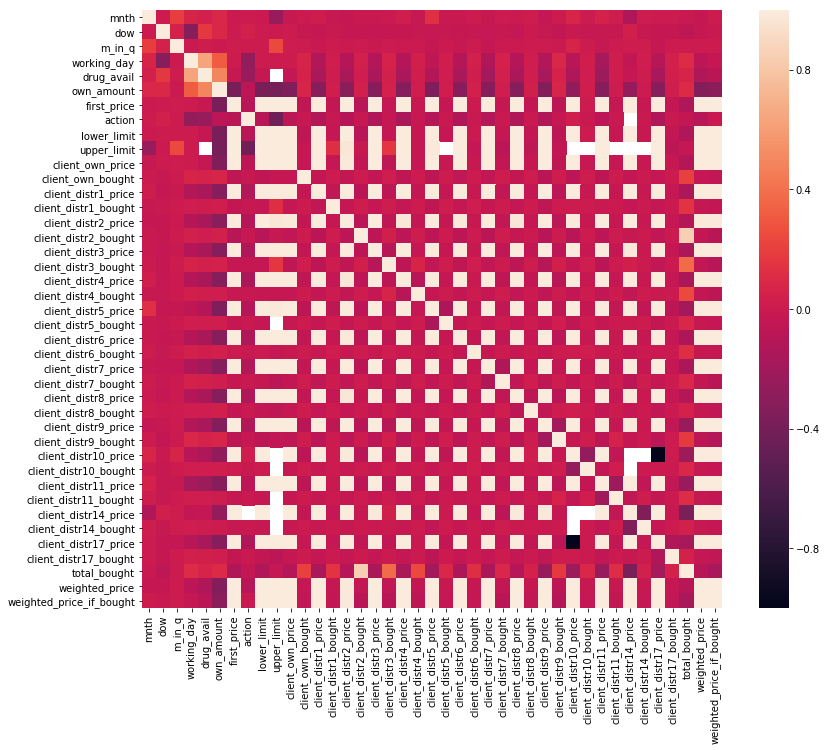

In [5]:
# finding correllations between features on complete dataset
corr = source_data.corr()

plt.figure(figsize=(13,11))

import seaborn as sns
# plot the heatmap
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns)
plt.show()

# Filtering data by client and drug

In [8]:
client_drug_data = source_data[(source_data['client_id'] == '90060000000002FE') & (source_data['drug_ag_id'] == '880000000000EEB7')]

drop_cols_list=['client_id', 'drug_ag_id', 'drug_name', 'mnth', 'dow', 'm_in_q', 'working_day', 'season', 'drug_avail', 'action', 'upper_limit', 'to_over_margin']
client_drug_data = client_drug_data.drop(drop_cols_list, axis = 1)

client_drug_data = client_drug_data.set_index('dt')
client_drug_data = client_drug_data.sort_index()

client_drug_data.head()

,own_amount,first_price,lower_limit,client_own_price,client_own_bought,client_distr1_price,client_distr1_bought,client_distr2_price,client_distr2_bought,client_distr3_price,client_distr3_bought,client_distr4_price,client_distr4_bought,client_distr5_price,client_distr5_bought,client_distr6_price,client_distr6_bought,client_distr7_price,client_distr7_bought,client_distr8_price,client_distr8_bought,client_distr9_price,client_distr9_bought,client_distr10_price,client_distr10_bought,client_distr11_price,client_distr11_bought,client_distr14_price,client_distr14_bought,client_distr17_price,client_distr17_bought,total_bought,weighted_price,weighted_price_if_bought
dt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,128.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN
2018-01-02,128.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN
2018-01-03,128.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN
2018-01-04,128.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN
2018-01-05,5.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN


# Time series (univariable)

In [0]:
def should_plot_series(series):
    return series.count() > 1

def get_price_series(column):
    series = client_drug_data[column]
    series = series.dropna(axis=0)
    series = series[series > 0]
    return series  


def try_plot_price_series(column, name, color = 'b'):
    series = get_price_series(column)
    should_plot = should_plot_series(series)
    if should_plot:
        series.plot(figsize=(10,3), title='Price of {}'.format(name), color=color)
        plt.show()
    return should_plot
  

def get_bought_series(column):
    series = client_drug_data[column]
    series = series.dropna(axis=0)
    series = series.astype(float)
    return series


def try_plot_bought_series(column, name, should_plot, color = 'r'):
    series = get_bought_series(column)
    if should_plot:
        series.plot(figsize=(10,3), title='Bought from {}'.format(name), color=color)
        plt.show()

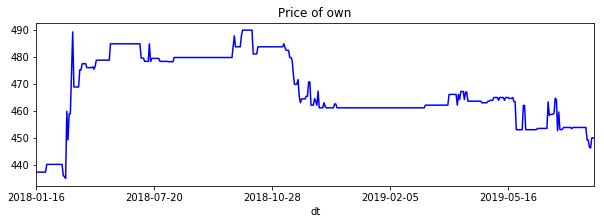

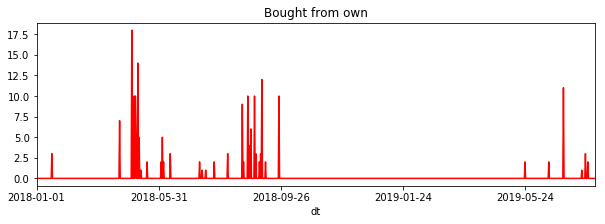

In [10]:
should_plot = try_plot_price_series('client_own_price', 'own')
try_plot_bought_series('client_own_bought', 'own', should_plot)

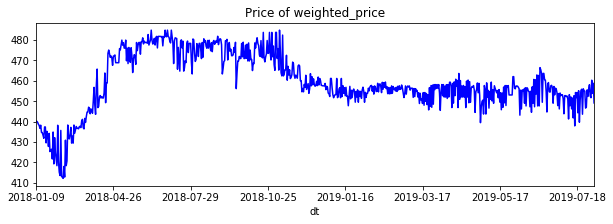

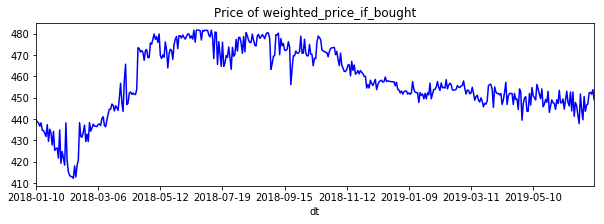

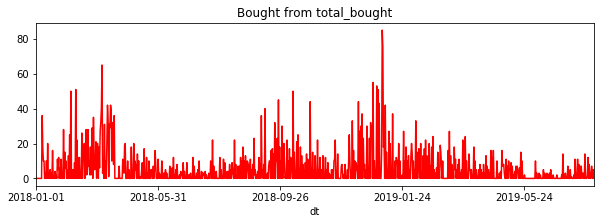

In [11]:
should_plot = try_plot_price_series('weighted_price', 'weighted_price')
try_plot_price_series('weighted_price_if_bought', 'weighted_price_if_bought')
try_plot_bought_series('total_bought', 'total_bought', should_plot)

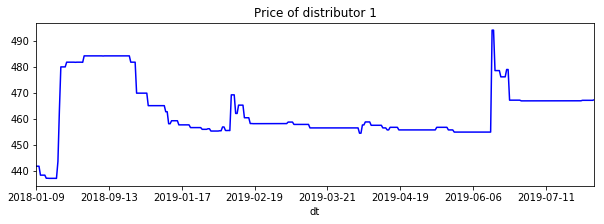

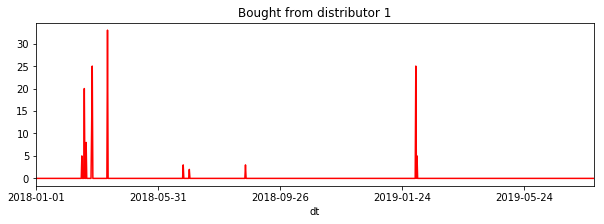

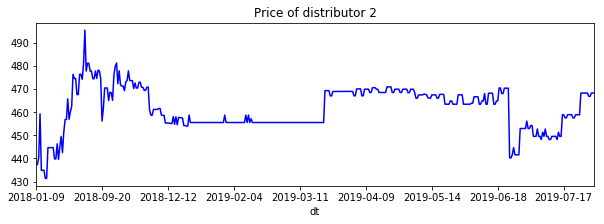

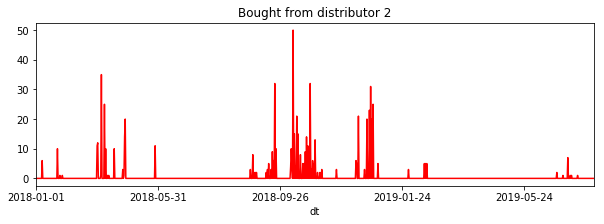

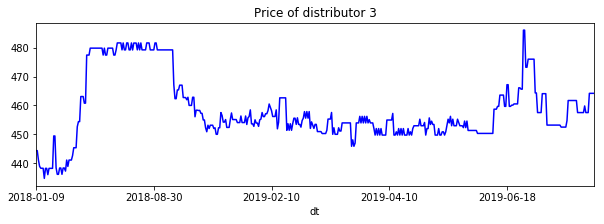

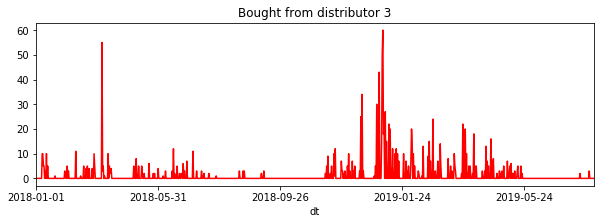

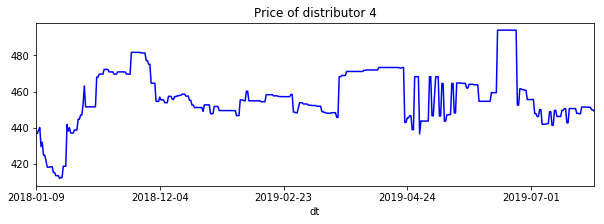

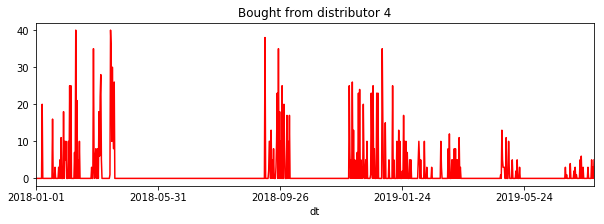

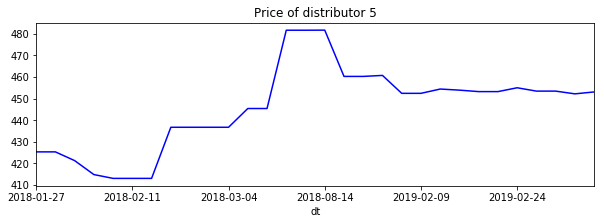

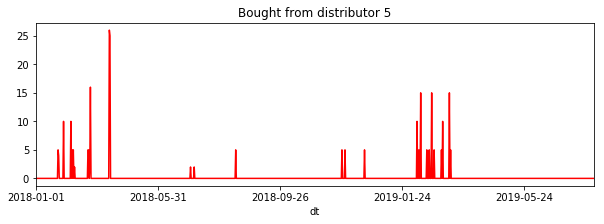

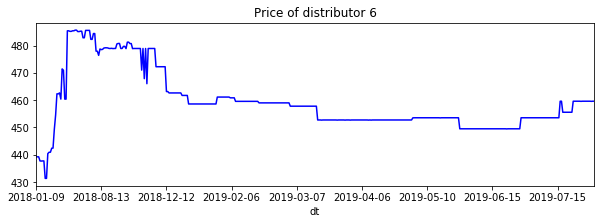

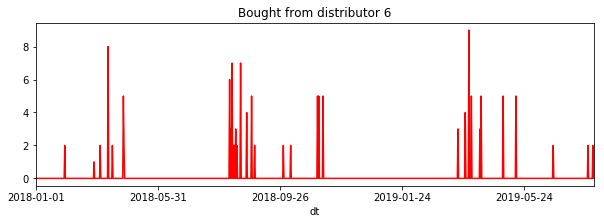

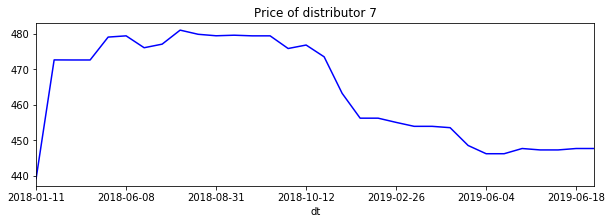

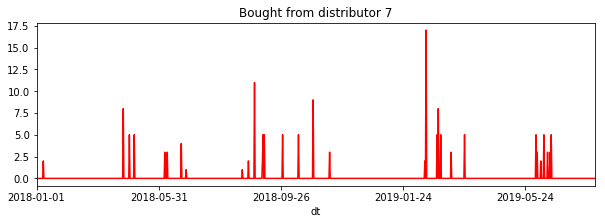

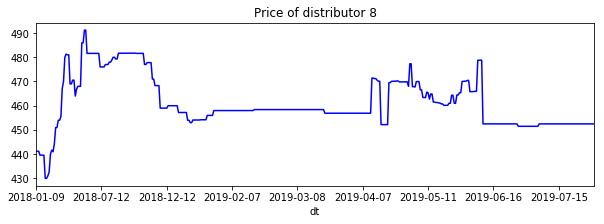

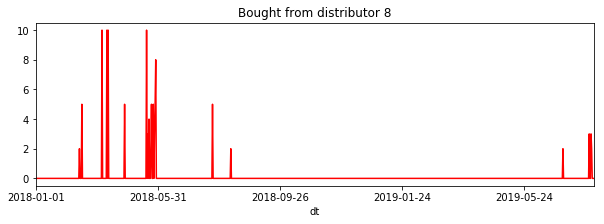

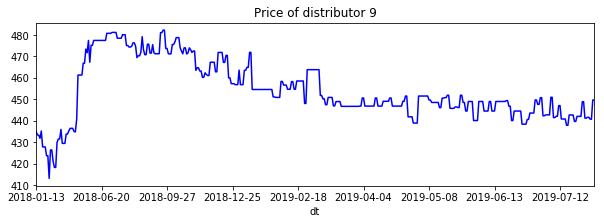

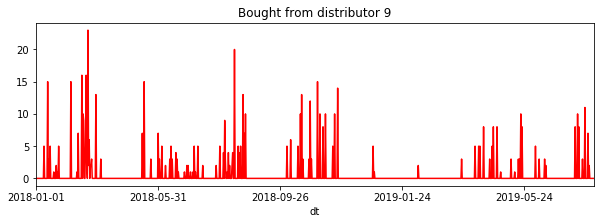

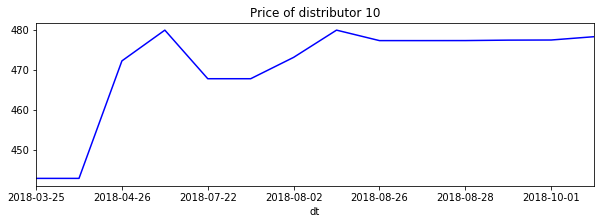

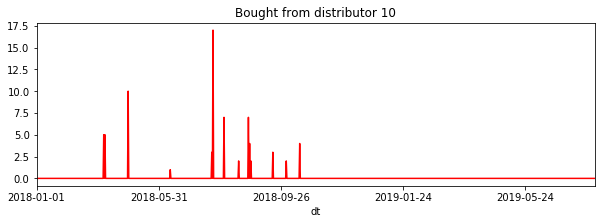

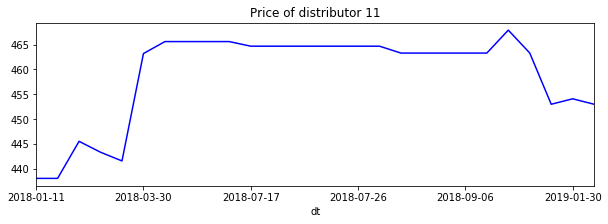

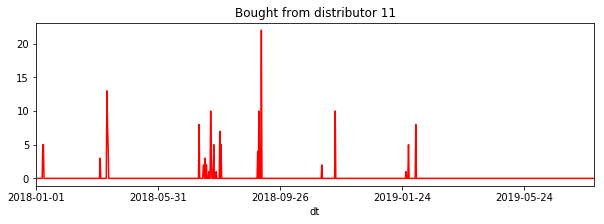

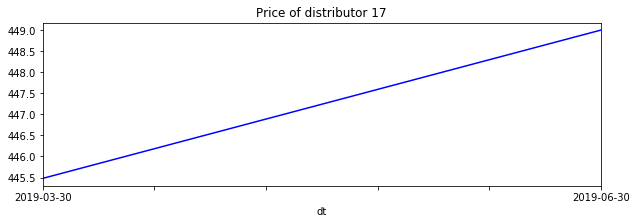

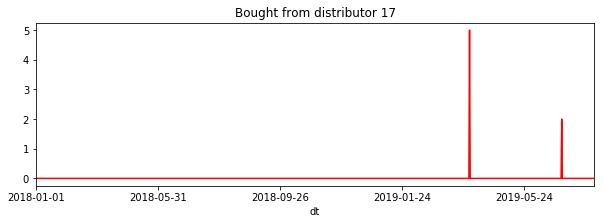

In [12]:
for i in known_distr_ids:
  should_plot_distr = try_plot_price_series('client_distr{}_price'.format(i), 'distributor {}'.format(i))
  try_plot_bought_series('client_distr{}_bought'.format(i), 'distributor {}'.format(i), should_plot_distr)

# Autocorellation

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


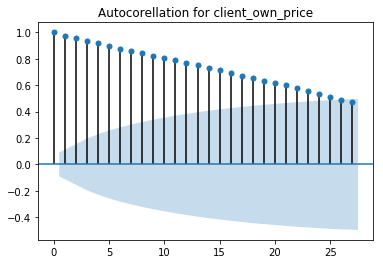

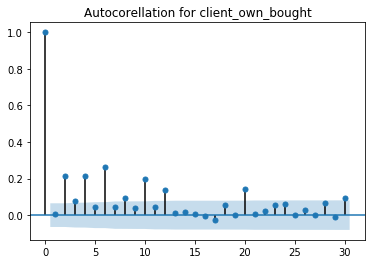

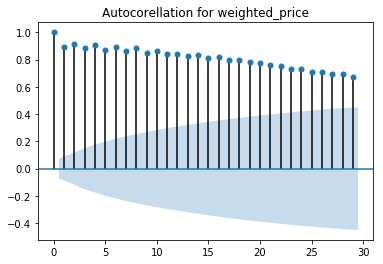

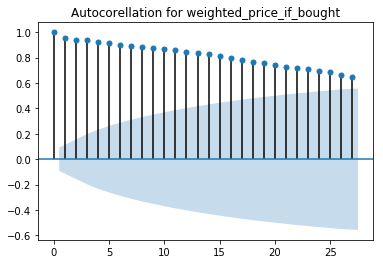

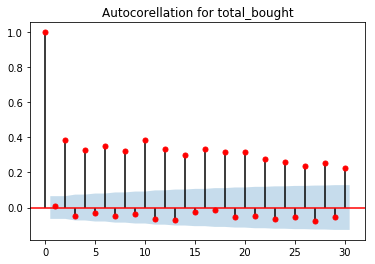

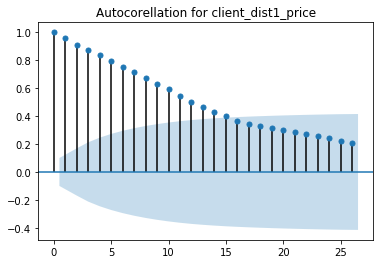

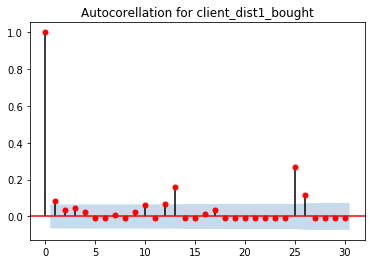

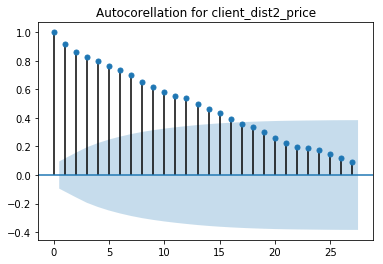

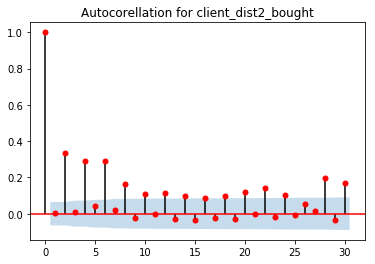

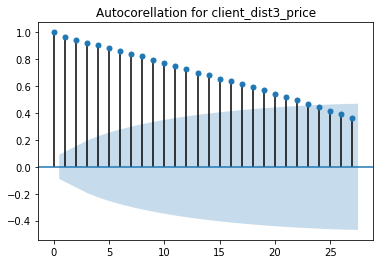

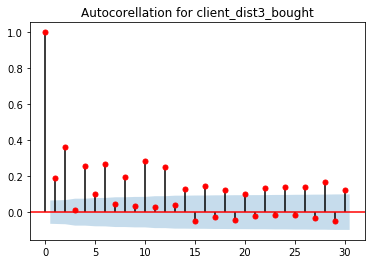

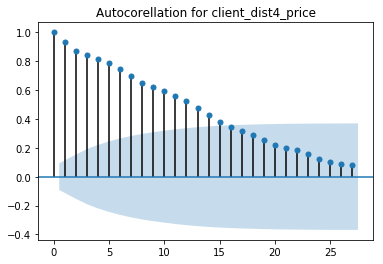

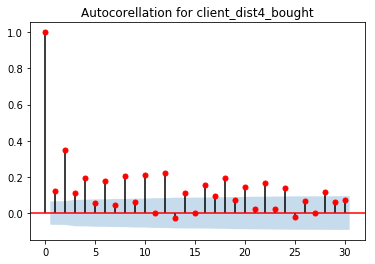

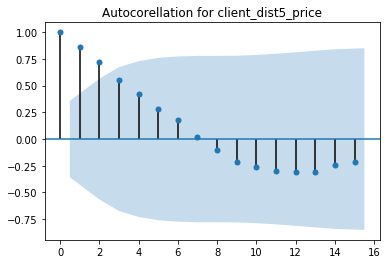

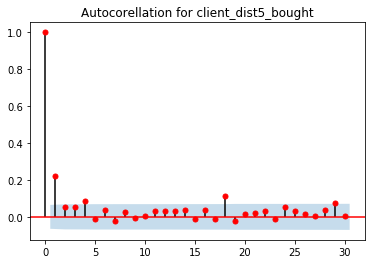

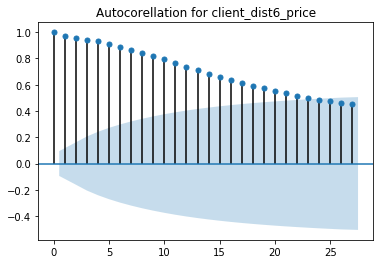

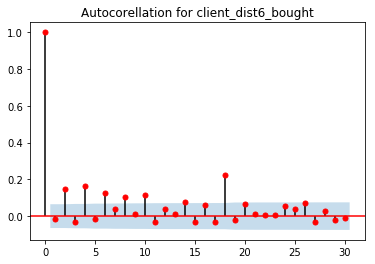

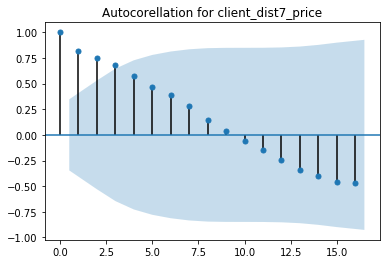

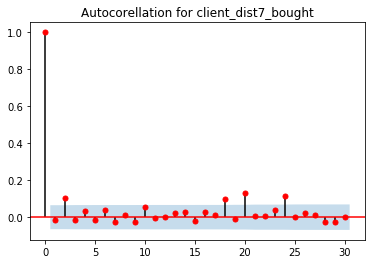

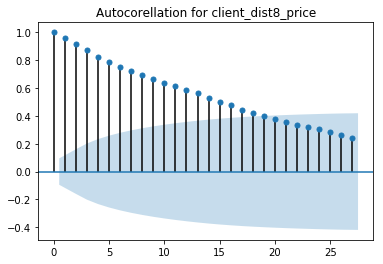

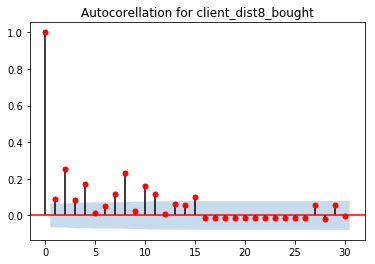

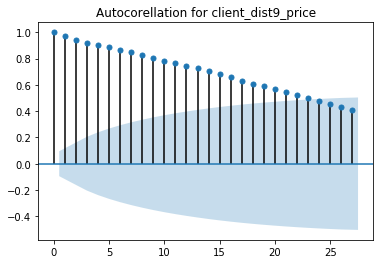

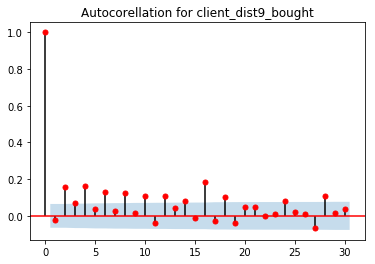

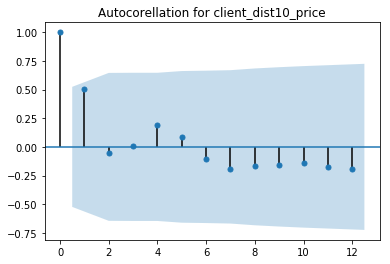

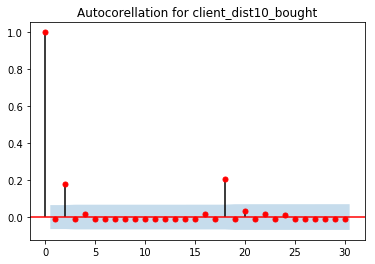

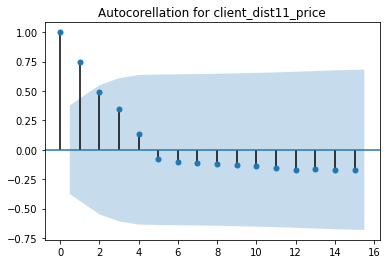

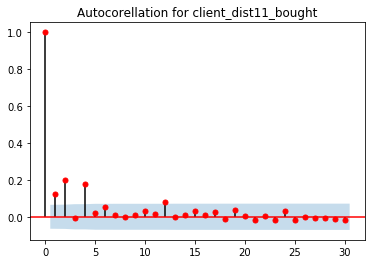

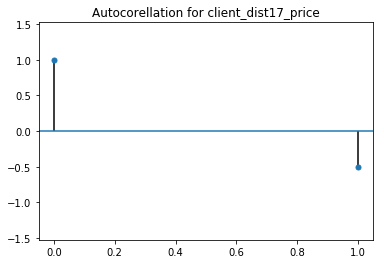

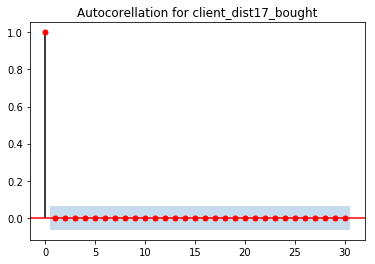

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(get_price_series('client_own_price'), title='Autocorellation for client_own_price')

plot_acf(get_bought_series('client_own_bought'), title='Autocorellation for client_own_bought')

plot_acf(get_price_series('weighted_price'), title='Autocorellation for weighted_price')

plot_acf(get_price_series('weighted_price_if_bought'), title='Autocorellation for weighted_price_if_bought')

plot_acf(get_bought_series('total_bought'), title='Autocorellation for total_bought', color='r')

for i in known_distr_ids:
  series_price = get_price_series('client_distr{}_price'.format(i))
  series_bought = get_bought_series('client_distr{}_bought'.format(i))
  if should_plot_series(series_price):
    plot_acf(series_price, title = 'Autocorellation for client_dist{}_price'.format(i))
    plot_acf(series_bought, title = 'Autocorellation for client_dist{}_bought'.format(i), color='r')

# VAR (Vector autoregressions)

In [0]:
# mdata = sm.datasets.macrodata.load_pandas().data
# mdata.head()

In [194]:
var_client_drug_data = source_data[(source_data['client_id'] == '90060000000002FE') & (source_data['drug_ag_id'] == '880000000000EEB7')]
drop_cols_list=['client_id', 'drug_ag_id', 'drug_name', 'mnth', 'dow', 'm_in_q', 'working_day', 'season', 'drug_avail', 'action', 'upper_limit', 'to_over_margin', 'first_price', 'lower_limit', \
                'own_amount',
                'client_distr1_bought', \
                'client_distr5_price', 'client_distr5_bought', \
                'client_distr9_bought', \
                'client_distr10_price', 'client_distr10_bought', \
                'client_distr11_price', 'client_distr11_bought', \
                'client_distr14_price', 'client_distr14_bought', \
                'client_distr17_price', 'client_distr17_bought', \
                'client_own_bought',
                'client_distr2_bought', \
                'client_distr3_bought', \
                'client_distr4_bought', 'client_distr4_price', \
                'client_distr6_bought', 'client_distr6_price', \
                'client_distr7_price', 'client_distr7_bought', \
                'client_distr8_price', 'client_distr8_bought', \
                'total_bought', \
                'weighted_price_if_bought', \
                'weighted_price']

var_client_drug_data = var_client_drug_data.drop(drop_cols_list, axis = 1)
#var_client_drug_data = var_client_drug_data[['dt', 'client_own_price', 'client_own_bought', 'client_distr1_price', 'client_distr1_bought', 'client_distr2_price', 'client_distr2_bought']]

var_client_drug_data.head()

,dt,client_own_price,client_distr1_price,client_distr2_price,client_distr3_price,client_distr9_price
50,2018-01-01,NaN,NaN,NaN,NaN,NaN
242,2018-01-02,NaN,NaN,NaN,NaN,NaN
434,2018-01-03,NaN,NaN,NaN,NaN,NaN
626,2018-01-04,NaN,NaN,NaN,NaN,NaN
818,2018-01-05,NaN,NaN,NaN,NaN,NaN


In [195]:
dates = var_client_drug_data[['dt']]
dates = dates.astype(str)
dates = dates.apply(lambda x: pd.to_datetime(x, format="%Y-%m-%d"))

var_data = var_client_drug_data.drop(['dt'], axis = 1)
var_data.index = pd.DatetimeIndex(dates)
var_data = var_data.dropna()
var_data = var_data.loc[(var_data!=0).all(axis=1)]
print(var_data.head())

model = VAR(var_data)

            client_own_price  client_distr1_price  client_distr2_price  \
2018-02-02            440.22           438.383834            431.38899   
2018-02-09            436.04           438.383834            444.66540   
2018-02-15            435.05           437.193715            444.66540   
2018-08-30            479.71           484.168412            477.68000   
2018-09-13            479.71           484.168412            474.37000   

            client_distr3_price  client_distr9_price  
2018-02-02            438.20000               423.69  
2018-02-09            449.43155               426.39  
2018-02-15            436.12840               418.25  
2018-08-30            479.28155               471.26  
2018-09-13            479.28155               481.11  


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [196]:
order = model.select_order(15)
print(order)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 8, BIC -> 1, FPE -> 6, HQIC -> 1>


In [0]:
#results = model.fit(maxlags=27, ic='aic')
results = model.fit(maxlags=9, ic='aic')

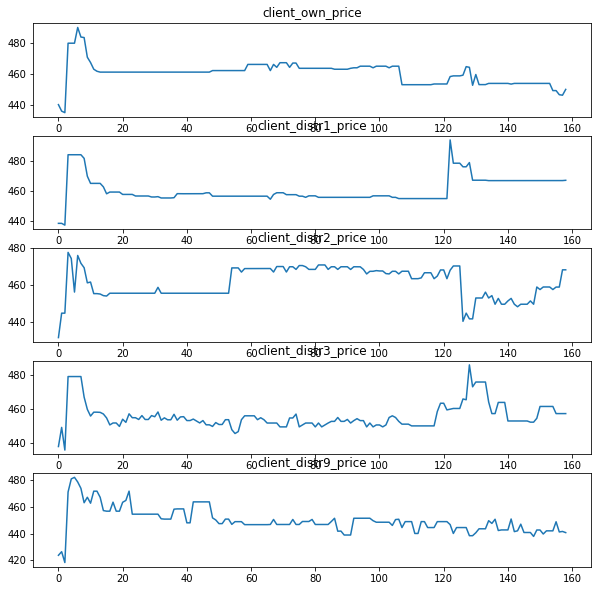

In [198]:
results.plot()
plt.show()

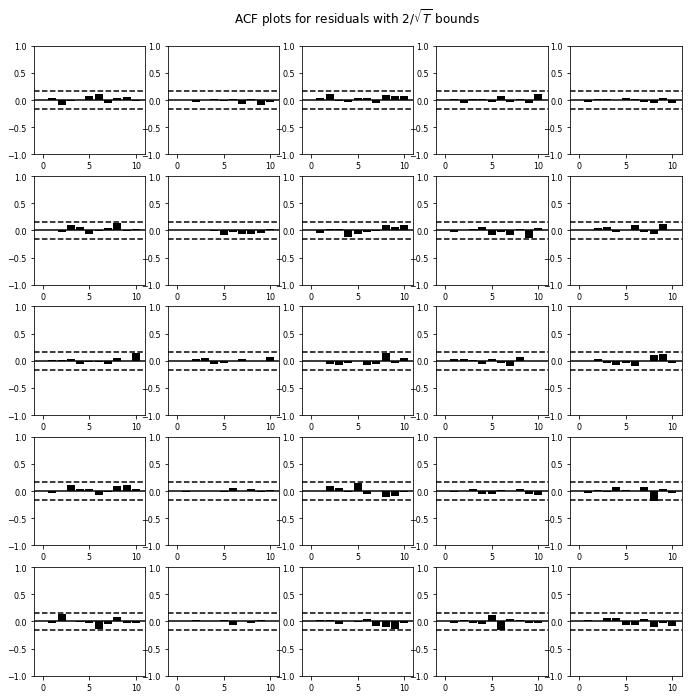

In [199]:
results.plot_acorr()
plt.show()

In [200]:
lag_order = results.k_ar
print('Lag order: ', lag_order)
print('##################################')
print('Forecast one day: ')
results.forecast(var_data.values[-lag_order:], 1)

Lag order:  8
##################################
Forecast one day: 


array([[449.74015753, 466.42677623, 464.67387194, 457.06631166,
        438.92318092]])

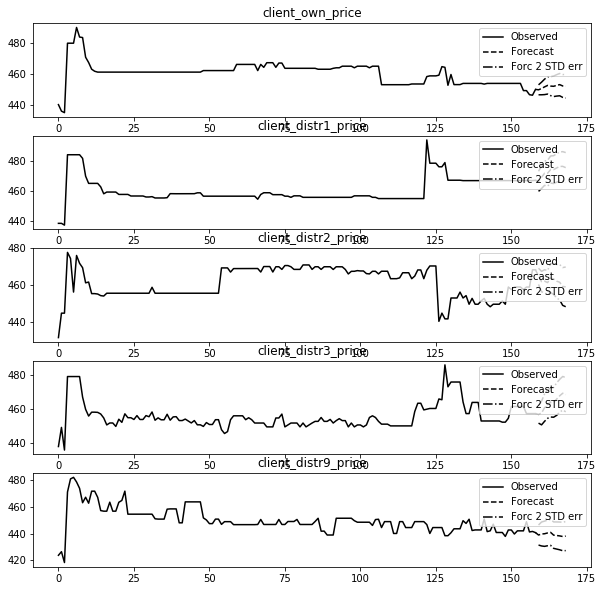

In [201]:
results.plot_forecast(10)
plt.show()

In [288]:
total_prediction_days = 30

columns = var_data.columns

count_rows = len(var_data.index)
print('Total rows: ', count_rows)

lag = math.nan

errors_data = pd.DataFrame()

result_data = pd.DataFrame();

for day_index in range(total_prediction_days):
    # cut out days of data
    var_prediction_data = var_data.head(count_rows - total_prediction_days + day_index)
    var_actual_result = var_data.tail(total_prediction_days - day_index).head(1)

    #print('Prediction data last: ')
    #print(var_prediction_data.tail(1))

    #print('Actual data:')
    #print(var_actual_result)

    prediction_model = VAR(var_prediction_data)

    selected_lag = model.select_order(15)
    #print('Selected lag: ', selected_lag)

    if math.isnan(lag):
        lag = selected_lag.aic

    predict_results = model.fit(maxlags=lag, ic='aic')

    actual_lag = predict_results.k_ar
    #print('Actual lag: ', actual_lag)
    
    forecast = predict_results.forecast(var_prediction_data.values, count_predicted)
    #print('Forecasts: ')
    #print(forecast)
    
    predicted_row = forecast[0]
    predicted_values = np.append(predicted_values, predicted_row)
    
    actual_row = var_actual_result.iloc[0]
    actual_values = np.append(actual_values, actual_row.values)
    
    error_row = {'actual_date': actual_row.name}
    result_data_row = {'actual_date': actual_row.name}
    for column_index in range(len(columns)):      
        column = columns[column_index]
        error_row[columns[column_index] + '_err'] = predicted_row[column_index] - actual_row[column]
        result_data_row[columns[column_index]] = actual_row[column]
        result_data_row[columns[column_index] + '_pred'] = predicted_row[column_index]
  
    #print('Errors:')
    #print(error_row)
    errors_data = errors_data.append(error_row, ignore_index=True)
    result_data = result_data.append(result_data_row, ignore_index=True)

Total rows:  159


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

# Графики предсказанных цен

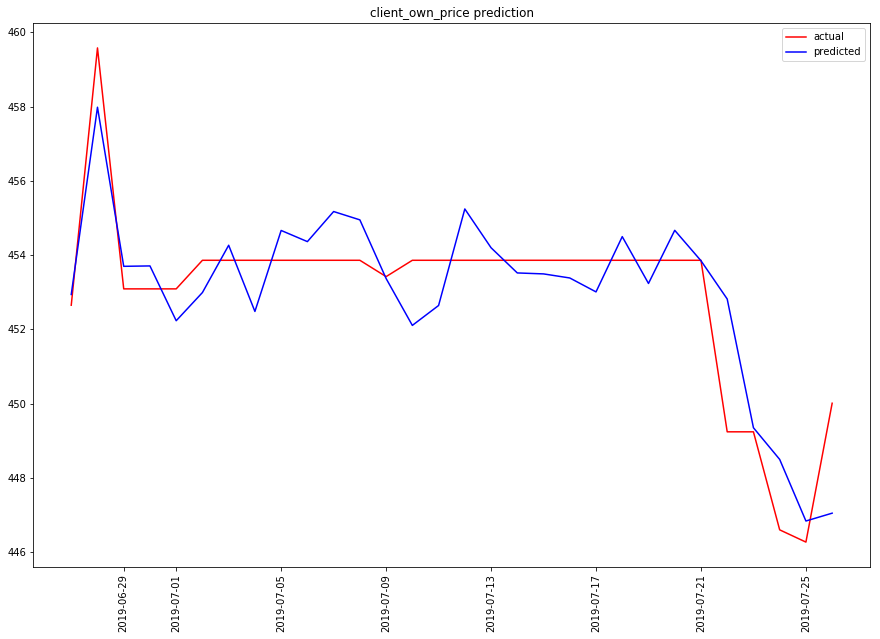

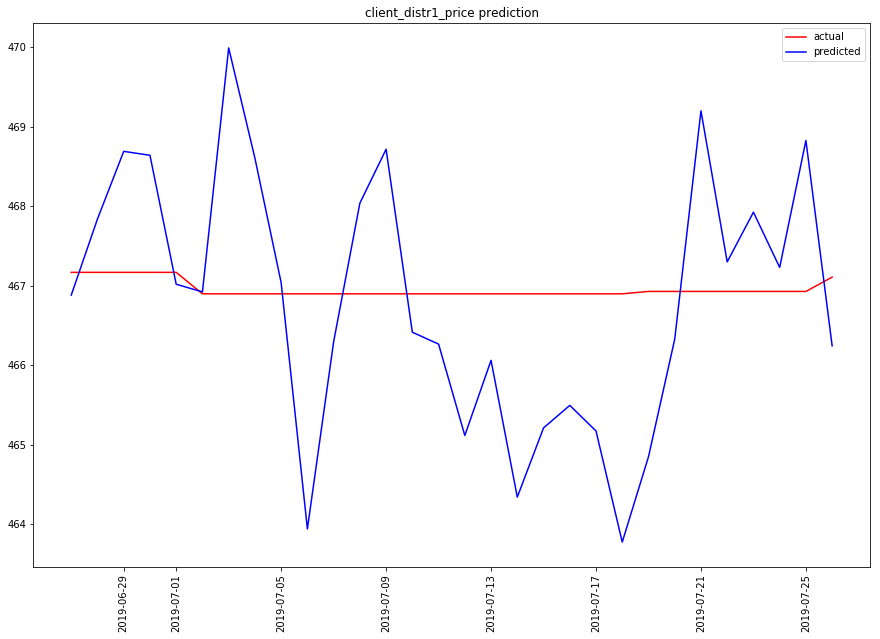

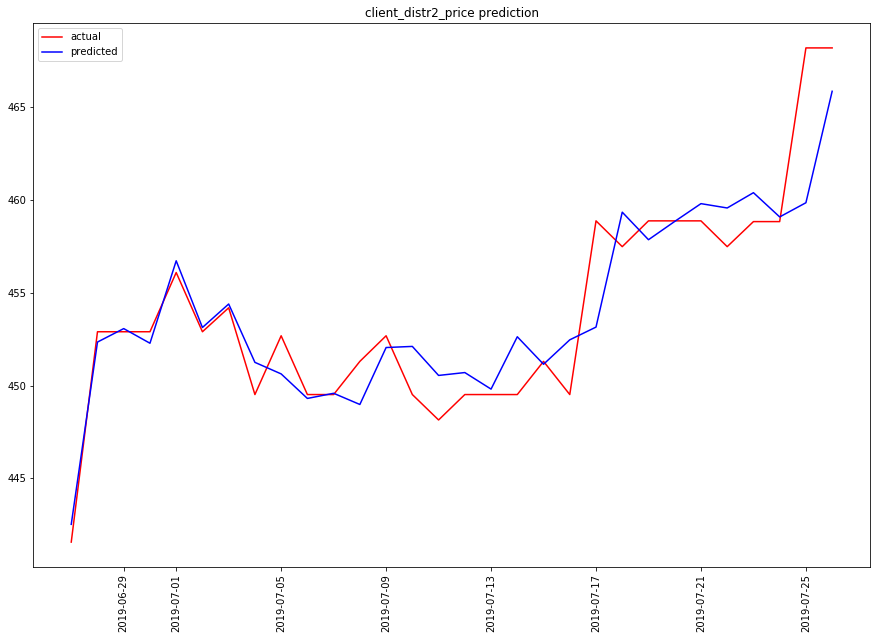

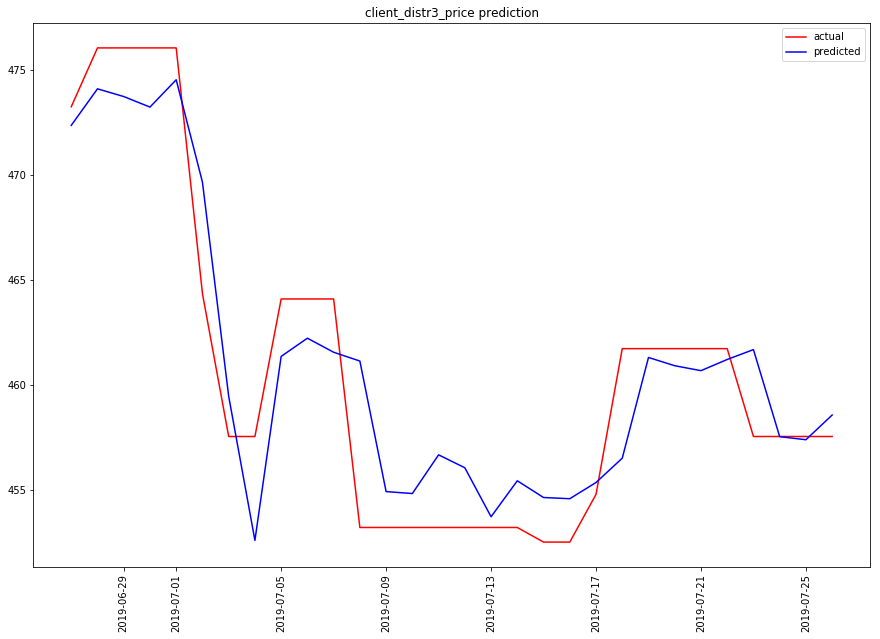

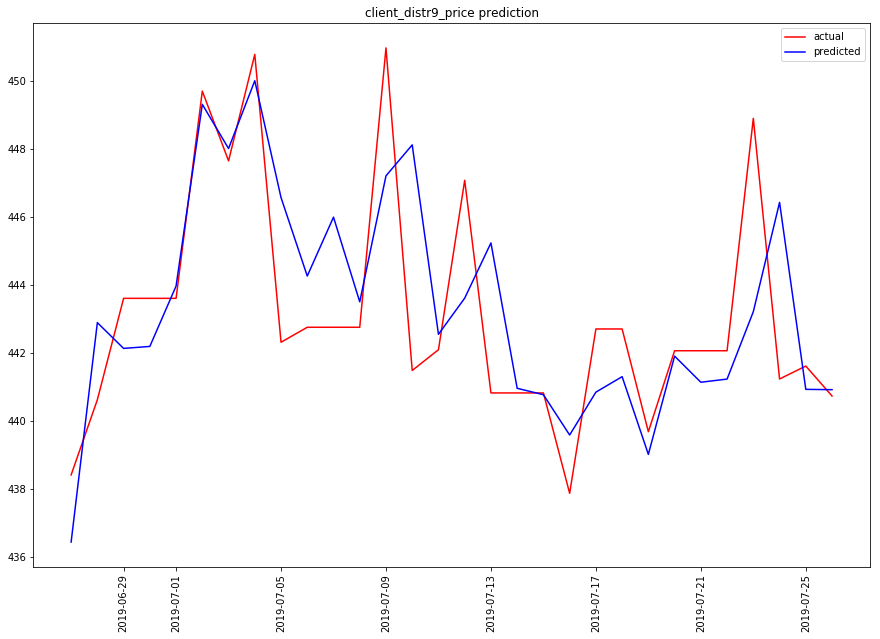

In [289]:
for column in columns: 
    plt.figure(figsize=(15,10))
    plt.plot(result_data.actual_date, result_data[column], color = 'red', label='actual')
    plt.plot(result_data.actual_date, result_data[column + '_pred'], color = 'blue', label='predicted')
    plt.xticks(rotation='vertical')
    plt.title(column + ' prediction')
    plt.legend()
    plt.show()